In [89]:
import json
import re
from datetime import datetime
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
pd.options.display.float_format = '{:.0f}'.format
import matplotlib.ticker as ticker

# BFC-BIC Analysis

This notebook lazily loads the dataset of all Linux Kernel commits (to load additional BFC and BIC message and author information) and the BFC-BIC dataset. It provides an analysis of the evolution of the number of BFCs and BICs per year, the duration of BICs from being introduced to being fixed and an analysis of the authors of BFCs and BICs.

In [2]:
def getCommits():
    with open('../linux-commits-2023-11-12.json') as f:
        for commit in f:
            yield json.loads(commit)

In [3]:
all_commits_map = {}
for commit in getCommits():
    all_commits_map[commit['data']['commit'][0:12]] = {
        'date': commit['data']['CommitDate'],
        'author': commit['data']['Author'],
    }

In [4]:
df = pd.read_csv('bfc_bic.csv')  
df.head()

,BFC_hash,BIC_hash,BFC_comment,BIC_comment,daysDistance,commitDistance
0,c56b097af26cb11c1f49a4311ba538c825666fed,5cedf721a7cdb54e9222133516c916210d836470,mm: list_lru: fix almost infinite loop causing...,list_lru: fix broken LRU_RETRY behaviour,49,3086
1,c511851de162e8ec03d62e7d7feecbdf590d881d,1c441e921201d523b5a6036aea22b0b426bf1af2,"Revert ""epoll: use freezable blocking call""",epoll: use freezable blocking call,171,25649
2,59612d187912750f416fbffe0c00bc0811c54ab5,9745cdb36da83aeec198650b410ca06304cf7928,"Revert ""select: use freezable blocking call""",select: use freezable blocking call,171,25649
3,ab1225901da2d4cd2dcbae6840e93abbef417064,2dc41281b1d1178befe4b76adf817570a7f45ec1,"Revert ""ACPI / hotplug / PCI: Avoid doing too ...",ACPI / hotplug / PCI: Avoid doing too much for...,53,11642
4,6920a1bd037374a632d585de127b6f945199dcb8,3ea67d06e4679a16f69f66f43a8d6ee4778985fc,memcg: remove incorrect underflow check,memcg: add per cgroup writeback pages accounting,49,2422


In [5]:
df['bfc_date'] = df.apply(lambda x: all_commits_map[x['BFC_hash'][0:12]]['date'], axis=1)
df['bfc_date'] = pd.to_datetime(df['bfc_date'], format='%a %b %d %H:%M:%S %Y %z', utc=True)
df['bic_date'] = df.apply(lambda x: all_commits_map[x['BIC_hash'][0:12]]['date'], axis=1)
df['bic_date'] = pd.to_datetime(df['bic_date'], format='%a %b %d %H:%M:%S %Y %z', utc=True)

### Distance in days

In [6]:
df['daysDistance'].describe()

count   90760
mean      646
std      1004
min         0
25%        45
50%       203
75%       795
max      6697
Name: daysDistance, dtype: float64

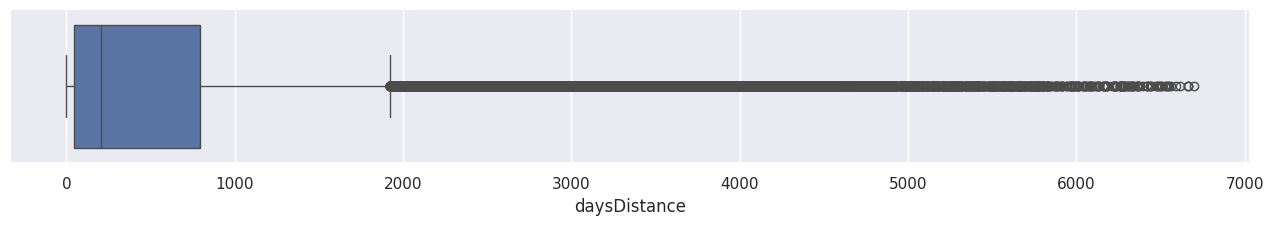

In [7]:
sns.set(rc={"figure.figsize":(16, 2)})
sns.boxplot(x=df['daysDistance'])
plt.show()

### Distance in commits

In [8]:
df['commitDistance'].describe()

count     90760
mean     140260
std      206257
min           1
25%       13765
50%       46136
75%      181358
max     1214794
Name: commitDistance, dtype: float64

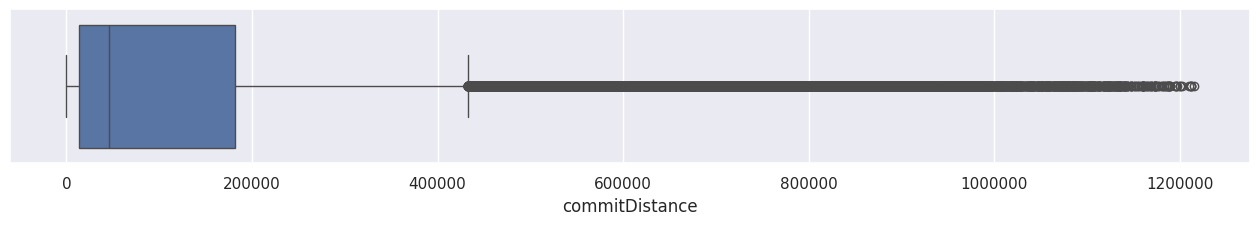

In [9]:
sns.boxplot(x=df['commitDistance'])
plt.gcf().axes[0].xaxis.get_major_formatter().set_scientific(False)
plt.show()

## Bugs fixed by year

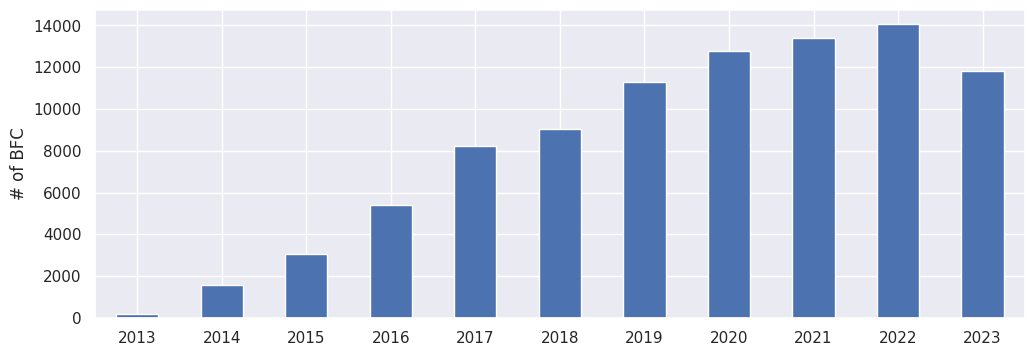

In [65]:
fig, axs = plt.subplots(figsize=(12, 4))
df.groupby(df["bfc_date"].dt.year)['bfc_date'].count().plot(kind='bar', rot=0, ax=axs)
plt.ylabel("# of BFC") 
plt.xlabel("")
plt.savefig('BFCPerYear.pdf');

## Bugs introduced by year

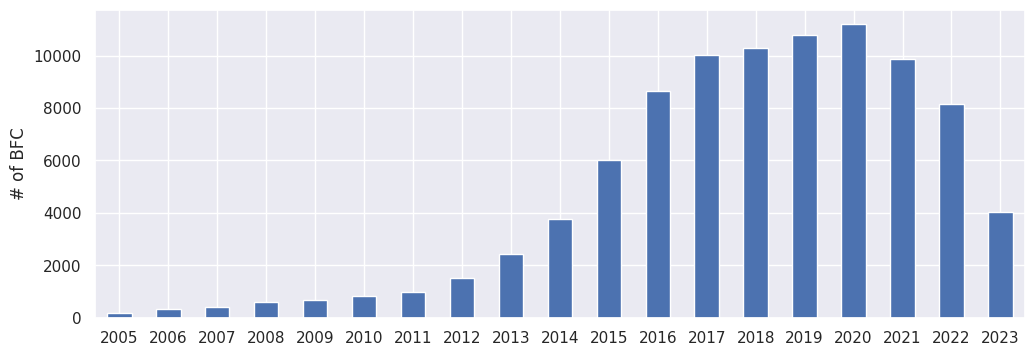

In [64]:
fig, axs = plt.subplots(figsize=(12, 4))
df.groupby(df["bic_date"].dt.year)['bic_date'].count().plot(kind='bar', rot=0, ax=axs)
plt.ylabel("# of BFC") 
plt.xlabel("");

## Bugs introduced and bugs fixed by year

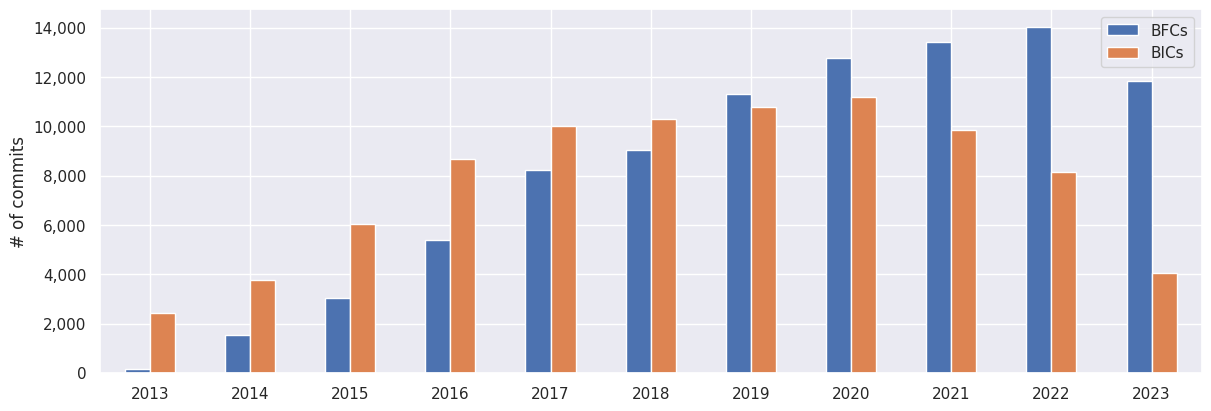

In [95]:
fig, axs = plt.subplots(figsize=(12, 4), layout="constrained")
g1 = df.groupby([df["bfc_date"].dt.year])[['bfc_date']].count()
g2 = df.groupby([df["bic_date"].dt.year])[['bic_date']].count()
df_combined = pd.concat([g1, g2], axis=1, keys=('BFCs','BICs'), join='inner')
axs.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
df_combined.plot(kind='bar', rot=0, ax=axs)
axs.legend(["BFCs", "BICs"]);
plt.ylabel("# of commits") 
plt.xlabel("")
plt.savefig('BFC_BIC_perYear.pdf');

## Life time of a bug fixed per year of correction

In [12]:
df['bicYearsOld'] = df.apply(lambda x: int(x['daysDistance'] / 360), axis=1)

<Axes: xlabel='bicYearsOld'>

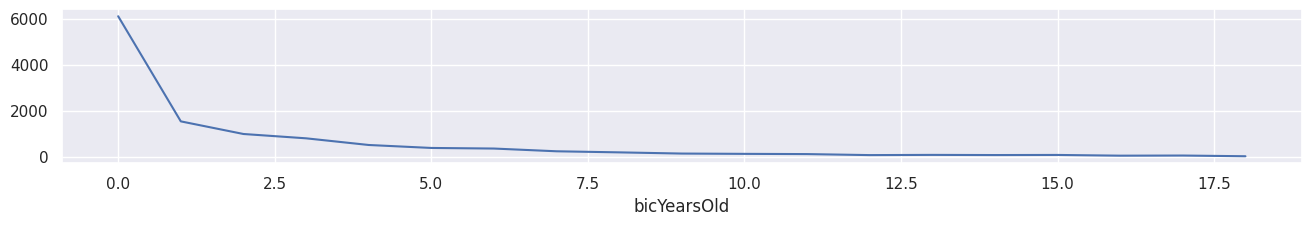

In [13]:
df_2023 = df[df['bfc_date'].dt.year == 2023].groupby(df['bicYearsOld'])['bfc_date'].count()
df_2023.plot()

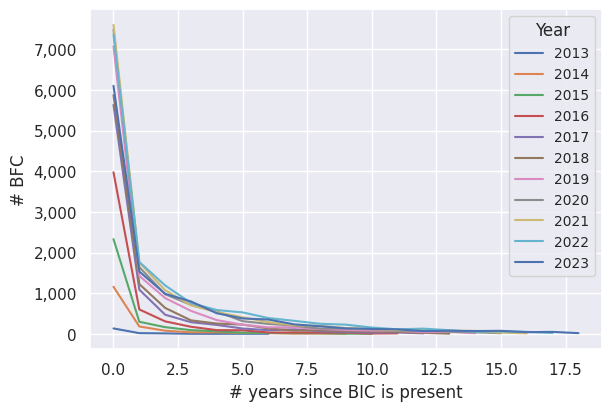

In [94]:
fig, axs = plt.subplots(figsize=(6, 4), layout="constrained")
df_bic = df[df['bfc_date'].dt.year > 2012]
df_bic = df_bic.groupby(['bicYearsOld',df_bic["bfc_date"].dt.year]).count()['bfc_date'].unstack()
ax = df_bic.plot(ax=axs)
ax.set_ylabel("# BFC");
ax.set_xlabel("# years since BIC is present")
axs.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
plt.legend(title="Year",loc=1, fontsize='small', fancybox=True)
plt.savefig('BIC_duration_perBFC_year.pdf');

## Authors of the BICs

* Distribución de BICs por desarrollador (probablmente caracterizada
por sus cuartiles, para tener una idea de cuántos BIC está
introduciendo cada desarrollador.

En ambos casos, hau que tener en cuenta que estos son umbrales
inferiores: habrá muchos otros casos, donde el BIC no está
identificado. Pero al menos para estos...

In [104]:
total_commiters=35856

In [97]:
df['BFC_author'] = df.apply(lambda x: all_commits_map[x['BFC_hash'][0:12]]['author'], axis=1)
df['BIC_author'] = df.apply(lambda x: all_commits_map[x['BIC_hash'][0:12]]['author'], axis=1)

#### Number of unique authors of BICs

In [105]:
bic_authors = df.groupby(df['BIC_author'])['BIC_author'].count().sort_values(ascending=False)
print("Total: ",len(bic_authors))
print("From all devs: ",len(bic_authors)/total_commiters)

Total:  9142
From all devs:  0.25496430165104866


#### Number of unique authors of BFCs

In [106]:
bfc_authors = df.groupby(df['BFC_author'])['BFC_author'].count().sort_values(ascending=False)
print("Total: ",len(bfc_authors))
print("From all devs: ",len(bfc_authors)/total_commiters)

Total:  8222
From all devs:  0.22930611334225792


#### Number cases where the BIC and the BFC author is the same

In [111]:
same_author = df[df['BFC_author']==df['BIC_author']]
print("Total: ",len(same_author))
print("From all links: ",len(same_author)/len(df.index))

Total:  26513
From all links:  0.29212208021154695
